In [105]:
# import packages 

import pandas as pd
import numpy as np
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

import itertools
import pickle
from mlxtend.plotting import plot_decision_regions
from mlxtend.classifier import StackingClassifier 


from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, 
                              AdaBoostClassifier, BaggingRegressor)

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn import datasets
from sklearn.preprocessing import Imputer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc


from dateutil.parser import parse
from datetime import datetime
import dateutil.parser

import matplotlib.pyplot as plt
%matplotlib inline


import glob
import os
import zipfile

import warnings
warnings.filterwarnings('ignore')



sns.set_style("whitegrid")

# Foraging For Wild Mushrooms

In this study, we will be reading in a kaggle dataset that includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family Mushroom drawn from The Audubon Society Field Guide to North American Mushrooms (1981). Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous one. The Guide clearly states that there is no simple rule for determining the edibility of a mushroom; no rule like "leaflets three, let it be'' for Poisonous Oak and Ivy.

We will be utilizing a number of supervised machine learning models to determine which mushrooms are poisonous and which are edible. To this end we will be using accuracy as our classification metric. To eat a mushroom that is poisonous can spell certain death in many cases, so we want to be ABSOLUTELY sure the mushroom we have identified is indeed edible.

With that said, let's dive in!

In [106]:
# read in shroom dataset
shroom_df = pd.read_csv('mushrooms.csv')

In [107]:
# basic EDA
shroom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
class                       8124 non-null object
cap-shape                   8124 non-null object
cap-surface                 8124 non-null object
cap-color                   8124 non-null object
bruises                     8124 non-null object
odor                        8124 non-null object
gill-attachment             8124 non-null object
gill-spacing                8124 non-null object
gill-size                   8124 non-null object
gill-color                  8124 non-null object
stalk-shape                 8124 non-null object
stalk-root                  8124 non-null object
stalk-surface-above-ring    8124 non-null object
stalk-surface-below-ring    8124 non-null object
stalk-color-above-ring      8124 non-null object
stalk-color-below-ring      8124 non-null object
veil-type                   8124 non-null object
veil-color                  8124 non-null object
ring-number

We see that all of the labels and our feature in the dataset are strings. We will need to convert them to integers in order to conduct this classification project. Let's first use the label encoder from sklearn to convert our target (edible vs. poisonous) into a 0-1 categorical.

In [108]:
from sklearn.preprocessing import LabelEncoder
# convert feature into 0-1 categorical
le = LabelEncoder()
shroom_df['class'] = le.fit_transform(shroom_df['class'])

Now, poisonous is represented by 1 and edible is represented by 0. Now, we can think of our classifier as “poisonous or not”. A poisonous mushroom gets a 1 (true), and an edible mushroom gets a 0 (false). Let's one-hot encode the rest of the features to continue with our analysis.

In [109]:
# get dummy variables for the remainder of the features (all currently objects). 
# lets also drop the first column so that we are not including our target in the encoded df!
encoded_df = pd.get_dummies(shroom_df, drop_first=True)

In [110]:
# ensure we do not have our target in the new df
encoded_df.columns

Index(['class', 'cap-shape_c', 'cap-shape_f', 'cap-shape_k', 'cap-shape_s',
       'cap-shape_x', 'cap-surface_g', 'cap-surface_s', 'cap-surface_y',
       'cap-color_c', 'cap-color_e', 'cap-color_g', 'cap-color_n',
       'cap-color_p', 'cap-color_r', 'cap-color_u', 'cap-color_w',
       'cap-color_y', 'bruises_t', 'odor_c', 'odor_f', 'odor_l', 'odor_m',
       'odor_n', 'odor_p', 'odor_s', 'odor_y', 'gill-attachment_f',
       'gill-spacing_w', 'gill-size_n', 'gill-color_e', 'gill-color_g',
       'gill-color_h', 'gill-color_k', 'gill-color_n', 'gill-color_o',
       'gill-color_p', 'gill-color_r', 'gill-color_u', 'gill-color_w',
       'gill-color_y', 'stalk-shape_t', 'stalk-root_b', 'stalk-root_c',
       'stalk-root_e', 'stalk-root_r', 'stalk-surface-above-ring_k',
       'stalk-surface-above-ring_s', 'stalk-surface-above-ring_y',
       'stalk-surface-below-ring_k', 'stalk-surface-below-ring_s',
       'stalk-surface-below-ring_y', 'stalk-color-above-ring_c',
       'stalk-color-

Before we continue, let's take a closer look at our target variable to see how balanced/imbalanced our classes are. This will determine if we need to do anything like oversampling (for class imbalance)

In [111]:
print(shroom_df.groupby('class').size())

class
0    4208
1    3916
dtype: int64


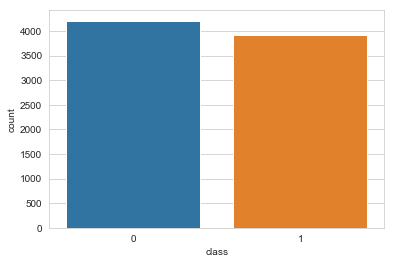

In [112]:
x = shroom_df['class']
class_plot = sns.countplot(x=x, data=shroom_df)

Looks like our two classes are almost perfectly balanced! Great, now let's begin modeling. Our first step is to split our dataset into our features and target (X and y respectively)

In [113]:
# split our dataset into features and target. Split for train/test
y = encoded_df['class'].values.reshape(-1,1)
X = encoded_df.drop(['class'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

Before we move on however, let's create a helper function for our training and testing across the different models.

In [114]:
def print_score(classifier,X_train,y_train,X_test,y_test,train=True):
    if train == True:
        print("Training results:\n")
        print('Accuracy Score: {0:.4f}\n'.format(accuracy_score(y_train,classifier.predict(X_train))))
        print('Classification Report:\n{}\n'.format(metrics.classification_report(y_train,classifier.predict(X_train))))
        print('Confusion Matrix:\n{}\n'.format(metrics.confusion_matrix(y_train,classifier.predict(X_train))))
        res = cross_val_score(classifier, X_train, y_train, cv=10, n_jobs=-1, scoring='accuracy')
        print('Average Accuracy:\t{0:.4f}\n'.format(res.mean()))
        print('Standard Deviation:\t{0:.4f}'.format(res.std()))
    elif train == False:
        print("Test results:\n")
        print('Accuracy Score: {0:.4f}\n'.format(accuracy_score(y_test,classifier.predict(X_test))))
        print('Classification Report:\n{}\n'.format(metrics.classification_report(y_test,classifier.predict(X_test))))
        print('Confusion Matrix:\n{}\n'.format(metrics.confusion_matrix(y_test,classifier.predict(X_test))))

### I. Logistic Regression

In [115]:
lg = LogisticRegression()
lg.fit(X_train,y_train.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [116]:
y_prob = lg.predict_proba(X_test)[:,1]   
y_pred = np.where(y_prob > 0.5, 1, 0) 
lg.score(X_test, y_pred)

1.0

In [122]:
lg.coef_

array([[ 5.40898026e-01, -2.04005641e-01, -1.21803470e-01,
        -5.32901612e-01, -3.63816072e-01,  1.00660868e+00,
         5.05453328e-01,  3.74841472e-01, -1.08952664e+00,
         1.22018015e-01, -1.11152096e-01, -4.29935387e-01,
         6.67002163e-01, -4.69772544e-01, -5.21976106e-01,
         2.50910484e-01, -5.36514536e-01, -4.09778675e-01,
         3.42813765e+00,  2.99544028e+00, -1.56733335e+00,
         2.68654947e-01, -4.05116137e+00,  3.06397848e+00,
         1.33654315e+00,  1.38393381e+00,  3.01430636e-01,
        -2.99714070e+00,  3.36538740e+00, -6.28204623e-01,
        -1.58412933e-01, -7.27747955e-02, -5.80698637e-01,
        -8.12641051e-01, -1.95339411e-01, -6.87689151e-01,
         7.00495637e-01, -2.11174355e-01, -5.45658591e-01,
         1.44586916e-01, -1.07382306e+00,  2.36598092e+00,
        -1.51912964e+00,  8.28280742e-01, -1.42704583e+00,
         1.83674906e+00, -6.83386345e-01,  2.61155132e-01,
         6.22431292e-01,  5.48465126e-02,  1.49243902e+0

In [13]:
scores = cross_val_score(lg, X, y, cv=10, scoring='accuracy')
print(scores)

[0.68511685 1.         1.         1.         0.99384994 1.
 1.         1.         0.86313194 1.        ]


In [14]:
# train score
print_score(lg,X_train,y_train,X_test,y_test,train=True)

Training results:

Accuracy Score: 0.9997

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3363
           1       1.00      1.00      1.00      3136

   micro avg       1.00      1.00      1.00      6499
   macro avg       1.00      1.00      1.00      6499
weighted avg       1.00      1.00      1.00      6499


Confusion Matrix:
[[3363    0]
 [   2 3134]]

Average Accuracy:	0.9995

Standard Deviation:	0.0007


In [15]:
# test score
print_score(lg,X_train,y_train,X_test,y_test,train=False)

Test results:

Accuracy Score: 0.9969

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       845
           1       1.00      0.99      1.00       780

   micro avg       1.00      1.00      1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625


Confusion Matrix:
[[845   0]
 [  5 775]]



In [125]:
logit_model=sm.Logit(y,X)
result=logit_model.fit()
result.summary()

         Current function value: inf
         Iterations: 35


LinAlgError: Singular matrix

In [16]:
auc_roc = metrics.roc_auc_score(y_test,y_pred)
auc_roc

0.9967948717948718

In [17]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.9999969655590957

Text(0.5, 0, 'False Positive Rate')

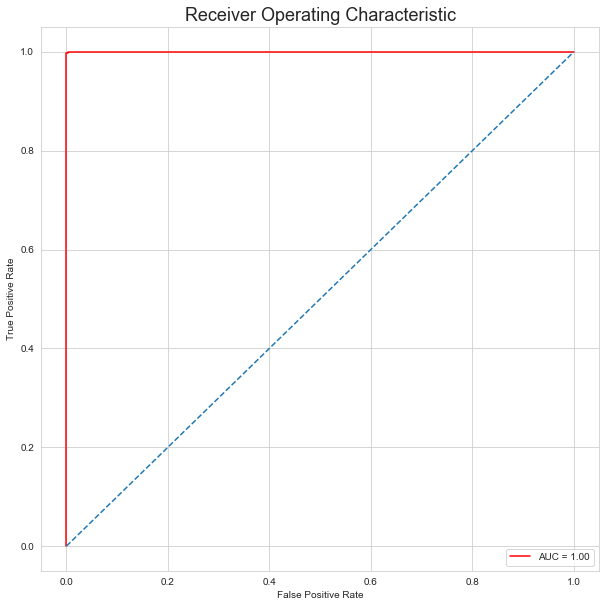

In [18]:
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic', fontsize = 18)
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

Well...it appears that logistic regression gives us a virtually perfect model. If I were stuck in the woods with no food, I'd opt for this model to determine whether or not I could eat a particular mushroom. For fun, however, let's look at some of the other methods available to us and see how they compare.

### II. Naive Bayes

In [19]:
model_naive = GaussianNB()
model_naive.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [20]:
y_prob = model_naive.predict_proba(X_test)[:,1]   
y_pred = np.where(y_prob > 0.5, 1, 0) 
model_naive.score(X_test, y_pred)

1.0

In [21]:
scores = cross_val_score(model_naive, X, y, cv=10, scoring='accuracy')
print(scores)

[0.66789668 0.96186962 0.91266913 0.88314883 0.95325953 0.95694957
 0.87931034 0.8546798  0.93341554 0.87916153]


In [22]:
# train score
print_score(model_naive,X_train,y_train,X_test,y_test,train=True)


Training results:

Accuracy Score: 0.9520

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      3363
           1       0.91      1.00      0.95      3136

   micro avg       0.95      0.95      0.95      6499
   macro avg       0.95      0.95      0.95      6499
weighted avg       0.96      0.95      0.95      6499


Confusion Matrix:
[[3051  312]
 [   0 3136]]

Average Accuracy:	0.9488

Standard Deviation:	0.0143


In [23]:
# test score
print_score(model_naive,X_train,y_train,X_test,y_test,train=False)

Test results:

Accuracy Score: 0.9502

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       845
           1       0.91      1.00      0.95       780

   micro avg       0.95      0.95      0.95      1625
   macro avg       0.95      0.95      0.95      1625
weighted avg       0.95      0.95      0.95      1625


Confusion Matrix:
[[767  78]
 [  3 777]]



In [24]:
auc_roc=metrics.roc_auc_score(y_test,y_pred)
auc_roc

0.9519230769230769

In [25]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.9927916856319223

Text(0.5, 0, 'False Positive Rate')

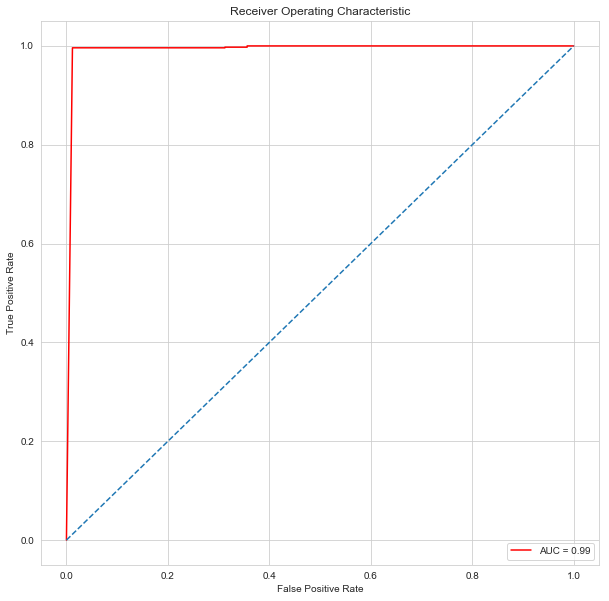

In [26]:
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

### III. Support Vector Machine

In [27]:
from sklearn.svm import SVC
classifier = SVC(kernel='rbf',random_state=42)
classifier.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False)

In [28]:
# train score
print_score(classifier,X_train,y_train,X_test,y_test,train=True)

Training results:

Accuracy Score: 0.9978

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3363
           1       1.00      1.00      1.00      3136

   micro avg       1.00      1.00      1.00      6499
   macro avg       1.00      1.00      1.00      6499
weighted avg       1.00      1.00      1.00      6499


Confusion Matrix:
[[3363    0]
 [  14 3122]]

Average Accuracy:	0.9972

Standard Deviation:	0.0015


In [29]:
# test score 
print_score(classifier,X_train,y_train,X_test,y_test,train=False)


Test results:

Accuracy Score: 0.9963

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       845
           1       1.00      0.99      1.00       780

   micro avg       1.00      1.00      1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625


Confusion Matrix:
[[845   0]
 [  6 774]]



### IV. KNN

In [30]:
from sklearn.neighbors import KNeighborsClassifier as KNN

knn = KNN()
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [31]:
y_prob = knn.predict_proba(X_test)[:,1]   
y_pred = np.where(y_prob > 0.5, 1, 0) 
knn.score(X_test, y_pred)

1.0

In [32]:
scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
print(scores)

[0.68757688 1.         1.         1.         1.         1.
 1.         1.         0.88902589 1.        ]


In [33]:
# train score
print_score(knn,X_train,y_train,X_test,y_test,train=True)


Training results:

Accuracy Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3363
           1       1.00      1.00      1.00      3136

   micro avg       1.00      1.00      1.00      6499
   macro avg       1.00      1.00      1.00      6499
weighted avg       1.00      1.00      1.00      6499


Confusion Matrix:
[[3363    0]
 [   0 3136]]

Average Accuracy:	0.9995

Standard Deviation:	0.0007


In [34]:
# test score
print_score(knn,X_train,y_train,X_test,y_test,train=False)

Test results:

Accuracy Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       845
           1       1.00      1.00      1.00       780

   micro avg       1.00      1.00      1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625


Confusion Matrix:
[[845   0]
 [  0 780]]



### V. Random Forest 

In [35]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 50, criterion = 'entropy', random_state = 42)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [37]:
# train score
print_score(forest,X_train,y_train,X_test,y_test,train=True)

Training results:

Accuracy Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3363
           1       1.00      1.00      1.00      3136

   micro avg       1.00      1.00      1.00      6499
   macro avg       1.00      1.00      1.00      6499
weighted avg       1.00      1.00      1.00      6499


Confusion Matrix:
[[3363    0]
 [   0 3136]]

Average Accuracy:	1.0000

Standard Deviation:	0.0000


In [38]:
# test score
print_score(forest,X_train,y_train,X_test,y_test,train=False)

Test results:

Accuracy Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       845
           1       1.00      1.00      1.00       780

   micro avg       1.00      1.00      1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625


Confusion Matrix:
[[845   0]
 [  0 780]]



Well, it appears that we just have data that is strongly indicative of whether or not a mushroom is poisonous or not. With the exception of Naive Bayes, we have a 99-100% accuracy across all our models. 

However, let's be practical here. While it is exciting to know that features of a mushroom (cap size, habitat etc.) can accuractely predict whether or not a mushroom is poisonous, it isn't terribly helpful in the real-world. For example, one wouldn't intuitively know all of these features if in the wild and searching for food. 

What most people do have on them, however, is a phone. Why don't we try then to classify mushrooms as being edible or not simply by their images.

For this, we will need to utilize tensorflow, keras and a new technique called deep learning.

Let's do it!

## Mushroom Image Classification

### Iteration 2

In [45]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tqdm import tqdm

In [46]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt

In [47]:
TRAIN_DIR = "mushroom_images"

In [48]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

Found 1436 images belonging to 2 classes.
Found 359 images belonging to 2 classes.


In [49]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 2))

In [50]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'edible': 0, 'poisonous': 1}


In [51]:
!cat labels.txt

edible
poisonous

In [52]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

In [53]:
base_model.trainable = False

In [69]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(2, activation='softmax')
])

In [70]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [71]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_5 ( (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 66        
Total params: 2,626,722
Trainable params: 368,738
Non-trainable params: 2,257,984
_________________________________________________________________


In [72]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


In [87]:
import os, shutil
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count))
    # Preprocess data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(img_width,img_height),
                                            batch_size = batch_size,
                                            class_mode='binary')
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
    
train_features = extract_features(TRAIN_DIR)  # Agree with our small dataset size
validation_features, validation_labels = extract_features(validation_dir, validation_size)
test_features, test_labels = extract_features(test_dir, test_size)

TypeError: extract_features() missing 1 required positional argument: 'sample_count'

In [86]:
from keras import models
from keras import layers
from keras import optimizers

epochs = 100

model = models.Sequential()
model.add(layers.Flatten(input_shape=(7,7,512)))
model.add(layers.Dense(256, activation='relu', input_dim=(7*7*512)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

# Compile model
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])
              
# Train model
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=(validation_features, validation_labels))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 6,423,041
Trainable params: 6,423,041
Non-trainable params: 0
_________________________________________________________________


NameError: name 'train_features' is not defined

In [101]:
files = glob.glob('mushroom_images/*')

edible = [fn for fn in files if 'edible' in fn]
poisonous = [fn for fn in files if 'poisonous' in fn]
len(edible), len(poisonous)

(1, 1)

In [100]:
edible_train = np.random.choice(edible_files, size=500, replace=False)
dog_train = np.random.choice(dog_files, size=1500, replace=False)
cat_files = list(set(cat_files) - set(cat_train))
dog_files = list(set(dog_files) - set(dog_train))

cat_test = np.random.choice(cat_files, size=500, replace=False)
dog_test = np.random.choice(dog_files, size=500, replace=False)

print('Cat datasets:', cat_train.shape, cat_val.shape, cat_test.shape)
print('Dog datasets:', dog_train.shape, dog_val.shape, dog_test.shape)

'edible'